# Dataset mean/std e visualizzazione normalizzata

Notebook per calcolare media e deviazione standard dei canali del dataset (in scala [0,1])
a partire dal manifest, e per visualizzare alcune immagini prima/dopo la normalizzazione
con quei valori. Utile per verificare se conviene usare statistiche del dataset invece delle
mean/std ImageNet.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Percorso del manifest da usare (train/val o altro)
manifest_path = "../manifests/train.csv"

# Limita il numero di immagini per calcoli veloci; None per usare tutto
sample_limit = None  # ad es. 500 per un subset rapido

# Se il manifest ha anche resized_path, usa quello come priorità
prefer_resized = True

# Mean/std ImageNet (RGB)
imagenet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [3]:
df = pd.read_csv(manifest_path)
base_dir = os.path.dirname(os.path.abspath(manifest_path))

def resolve_path(row):
    candidates = []
    if prefer_resized and "resized_path" in row:
        candidates.append(row.get("resized_path"))
    candidates.append(row.get("image_path"))
    for p in candidates:
        if p is None or (isinstance(p, float) and np.isnan(p)):
            continue
        p = str(p).strip()
        if not p:
            continue
        if not os.path.isabs(p):
            p = os.path.join(base_dir, p)
        return os.path.abspath(p)
    return None

df["resolved_path"] = [resolve_path(r) for _, r in df.iterrows()]
df = df[df["resolved_path"].notna()].reset_index(drop=True)
exists_mask = df["resolved_path"].apply(os.path.exists)
if not exists_mask.all():
    print(f"Skipping {len(df) - exists_mask.sum()} missing files")
    df = df[exists_mask].reset_index(drop=True)

if sample_limit is not None:
    df = df.sample(n=min(sample_limit, len(df)), random_state=42).reset_index(drop=True)

print(f"Using {len(df)} images for statistics")

Using 16064 images for statistics


In [4]:
channel_sum = np.zeros(3, dtype=np.float64)
channel_sq_sum = np.zeros(3, dtype=np.float64)
pixel_count = 0

def to_rgb(img):
    if img.ndim == 2:
        return np.stack([img] * 3, axis=-1)
    if img.shape[2] == 1:
        return np.repeat(img, 3, axis=2)
    return img[:, :, :3]

for path in tqdm(df["resolved_path"], desc="Accumulating stats"):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        continue
    img = to_rgb(img).astype(np.float32)
    mask = (img.sum(axis=2) > 0)  # ignora pad completamente nero
    if not mask.any():
        continue
    img = img[mask] / 255.0  # coerenza con pipeline (valori in [0,1])
    channel_sum += img.sum(axis=0)
    channel_sq_sum += (img * img).sum(axis=0)
    pixel_count += img.shape[0]

mean = channel_sum / pixel_count
std = np.sqrt(channel_sq_sum / pixel_count - mean ** 2)

print("Mean per channel (mascherando pad nero):", mean)
print("Std per channel:", std)

Accumulating stats: 100%|██████████| 16064/16064 [02:04<00:00, 129.17it/s]

Mean per channel (mascherando pad nero): [0.22099896 0.36832668 0.29886591]
Std per channel: [0.1620499  0.16048366 0.20173508]


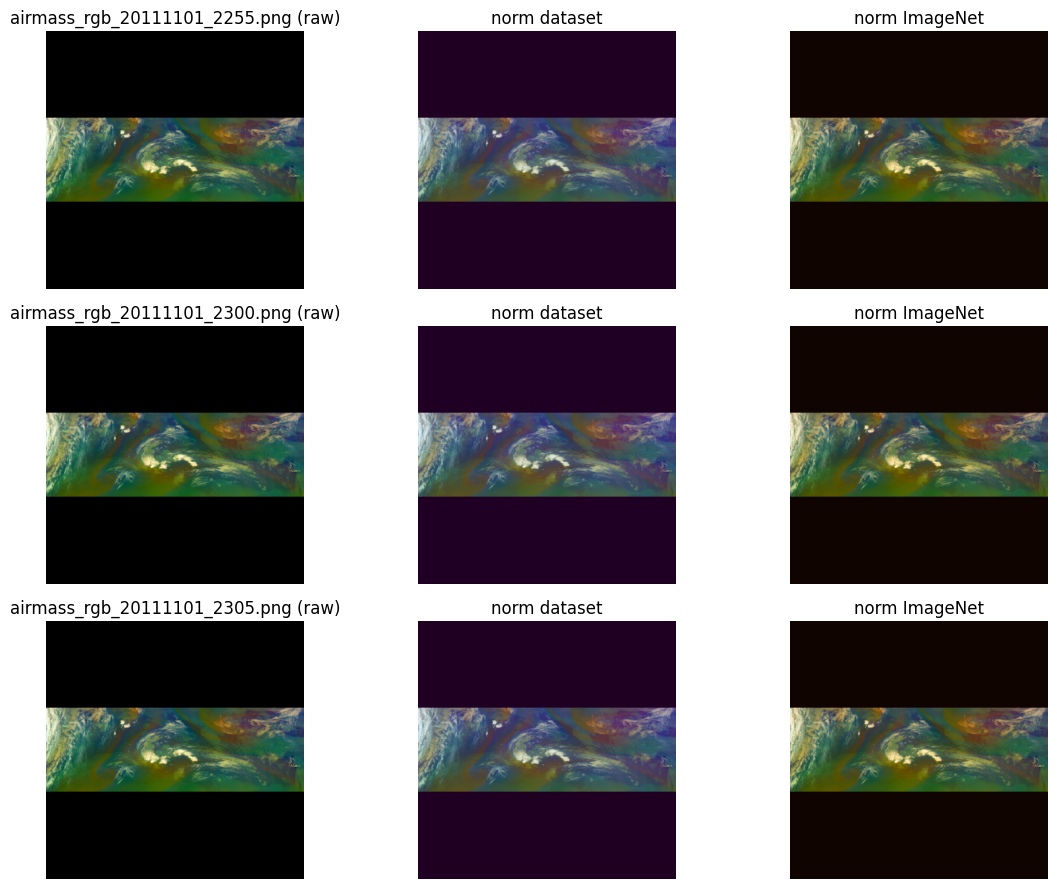

In [5]:
# Visualizza alcune immagini prima/dopo normalizzazione
n_show = min(3, len(df))
sample_paths = df["resolved_path"].head(n_show).tolist()


def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img[..., None] if img.ndim == 2 else img
    img = img[:, :, :3]
    img = img.astype(np.float32) / 255.0
    return img

fig, axes = plt.subplots(n_show, 3, figsize=(12, 3 * n_show))
if n_show == 1:
    axes = np.expand_dims(axes, 0)

for i, p in enumerate(sample_paths):
    img = load_img(p)

    norm_ds = (img - mean) / std
    norm_imn = (img - imagenet_mean) / imagenet_std

    # Per visualizzare, rimappiamo le versioni normalizzate in [0,1]
    def to_vis(arr):
        arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
        return arr.astype(np.float32)

    norm_ds_vis = to_vis(norm_ds)
    norm_imn_vis = to_vis(norm_imn)

    axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(os.path.basename(p) + " (raw)")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(norm_ds_vis, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("norm dataset")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(cv2.cvtColor(norm_imn_vis, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title("norm ImageNet")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

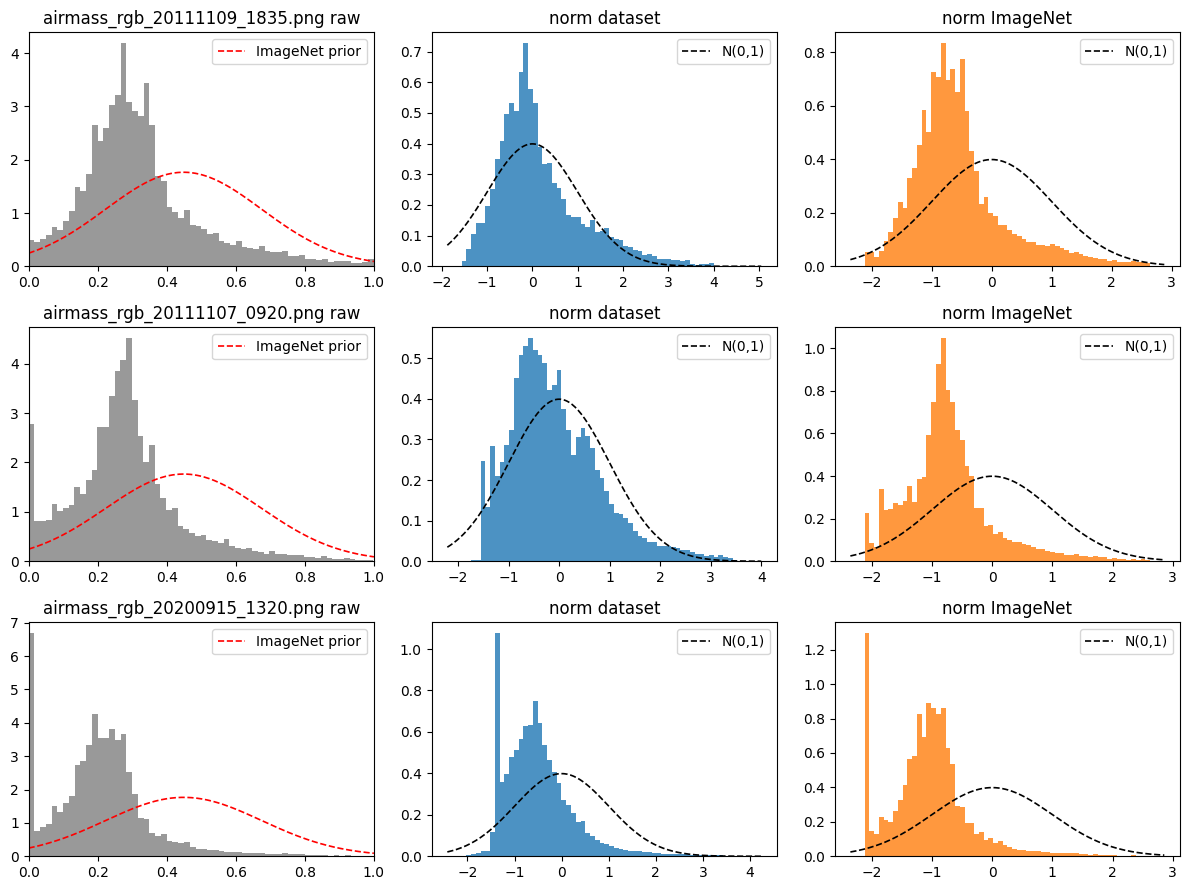

In [8]:
# Istogrammi di intensità (raw vs normalizzazioni) su 3 campioni random
n_hist = min(3, len(df))
sample_paths_hist = np.random.choice(df["resolved_path"], size=n_hist, replace=False)

fig, axes = plt.subplots(n_hist, 3, figsize=(12, 3 * n_hist))
if n_hist == 1:
    axes = np.expand_dims(axes, 0)

def flatten(img):
    return img.reshape(-1)

def plot_expected(ax, mean_val, std_val, color="k", label="expected"):
    xmin, xmax = ax.get_xlim()
    xs = np.linspace(xmin, xmax, 200)
    pdf = 1.0 / (std_val * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((xs - mean_val) / std_val) ** 2)
    ax.plot(xs, pdf, color=color, linestyle="--", linewidth=1.2, label=label)
    ax.legend()

imagenet_mean_scalar = float(np.mean(imagenet_mean))
imagenet_std_scalar = float(np.mean(imagenet_std))

for i, p in enumerate(sample_paths_hist):
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    img = img[..., None] if img.ndim == 2 else img
    img = img[:, :, :3].astype(np.float32)
    mask = (img.sum(axis=2) > 0)
    if not mask.any():
        continue

    raw = img[mask] / 255.0
    norm_ds = (raw - mean) / std
    norm_imn = (raw - imagenet_mean) / imagenet_std

    axes[i, 0].hist(flatten(raw), bins=60, color="gray", alpha=0.8, density=True)
    axes[i, 0].set_title(f"{os.path.basename(p)} raw")
    axes[i, 0].set_xlim(0, 1)
    plot_expected(axes[i, 0], imagenet_mean_scalar, imagenet_std_scalar, color="red", label="ImageNet prior")

    axes[i, 1].hist(flatten(norm_ds), bins=60, color="tab:blue", alpha=0.8, density=True)
    axes[i, 1].set_title("norm dataset")
    plot_expected(axes[i, 1], 0.0, 1.0, color="black", label="N(0,1)")

    axes[i, 2].hist(flatten(norm_imn), bins=60, color="tab:orange", alpha=0.8, density=True)
    axes[i, 2].set_title("norm ImageNet")
    plot_expected(axes[i, 2], 0.0, 1.0, color="black", label="N(0,1)")

plt.tight_layout()
plt.show()